In [173]:
%matplotlib inline
from collections import Counter
from collections import defaultdict
import glob
from decimal import Decimal
import os
import seaborn as sns
import pandas as pd
from matplotlib import image
import numpy as np
import pybedtools
import subprocess
from gscripts.general import dataviz
from collections import OrderedDict
from clipper.src import CLIP_analysis

img_dir = "/nas3/gpratt/Dropbox/TAF15/Data/GP_TAF15_CLIP_motif/"

In [174]:
name_map = {"taf15": "TAF15",
           "fus": "FUS",
           "tdp43": "TDP43"}

style_map = {"taf15": "-",
           "fus": "--",
           "tdp43": "--"}

color_map = {"fus": '#43A247',
              'taf15': '#DB1D3D',
              'tdp43': '#712878',
              'fus_taf15': 'c',
              'taf15_tdp43': 'c'}

background_dict_map = {"TDP43brainclip": "tdp43",
                       "TAF15": "taf15",
                       "TLS": "fus",}

In [175]:
#motif generation code
#example
#/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/all/homerResults -> scanMotifGenomeWide.pl motif1.motif mm9 -bed > motif1.bed
    
#sorting code
#sort -k 1,1 -k 2,2n motif1.bed > motif1.sorted.bed

In [204]:
def closest_hist(bedtool, motiftool):
    cloest_tool = bedtool.closest(motiftool, s=True, D="a", t="first")
    distances = [int(interval[-1]) for interval in cloest_tool if interval[9] != "none"]
    hist, bins = np.histogram(distances, range=(-500, 500), bins=50)
    bins = [(bins[n] + bins[n+1]) / 2 for n in range(len(bins) - 1)]
    normalized_hist = hist / (len(bedtool) * 1.0)
    return normalized_hist, bins

def get_midpoint(interval):
    midpoint = (interval.start + interval.end) / 2
    interval.start = midpoint
    interval.end = midpoint + 1
    return interval

def get_homer_values(fn):
    with open(fn) as motif:
        header = motif.readline().strip().split()
        stats = header[-1].split(",")
        pvalue = Decimal(stats[2].split(":")[1])
        target = float(stats[0].split("(")[1][:-2])
        background = float(stats[1].split("(")[1][:-2])
        return target, background, pvalue

def move_name(interval):
    interval.name = interval[12]
    return interval

def annotatePeaks(peaks, motif, species="hg19", hist=10, size=1000):
    
    """
    
    runs homer with standard args
    output location is saved
    
    foreground - str, location of fasta file for the foreground distribution
    background - str, location of fasta file for the background distribution
    k - different k-mers to examine
    outloc - directory to output homer results 

    --make optional make work off locations and not fasta files 
    
    """
    #findMotifs.pl clusters.fa fasta outloc -nofacts p 4 -rna -S 10 -len 5,6,7,8,9 -noconvert -nogo -fasta background.fa
    #converts k to a string for use in subprocess
    #I'm forgetting strand specific information here
    try:
        with open("tmp.txt", 'w') as out:
            subprocess.call(["annotatePeaks.pl",
                             peaks,
                             species,
                             "-m", motif,
                             "-hist", str(hist),
                             "-size", str(size),
                             "-noann"], shell=False, stdout=out)
    except OSError:
        print "Homer not installed, ignoring motif generation, install homer for this to work"  
        raise   
    return pd.read_table("tmp.txt", index_col=0)

In [177]:
motifs = {"all_motif_1": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/all/homerResults/motif1.sorted.bed"),
          "all_motif_2": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/all/homerResults/motif2.sorted.bed"),
          "utr3_motif_1": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/three_prime_utrs/homerResults/motif1.sorted.bed"),
          "utr3_motif_2": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/three_prime_utrs/homerResults/motif2.sorted.bed"),
          }

background = glob.glob("/nas3/gpratt/iPython_Notebook/taf15/assigned/*bed.all.rand*")
background_rbps = {os.path.basename(bedtool): pybedtools.BedTool(bedtool).each(get_midpoint).sort().saveas() for bedtool in background}

In [183]:
rbps = {"taf15": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/analysis/mouse_clip_v5/TAF15_WholeBrain.merged.peaks.kasey.bed"),
        'tdp43': pybedtools.BedTool("/nas3/gpratt/projects/fet_family/analysis/mouse_clip_v5/TDP43_WholeBrain.merged.peaks.kasey.bed"),
        'fus': pybedtools.BedTool("/nas3/gpratt/projects/fet_family/analysis/mouse_clip_v5/TLS_WholeBrain.merged.peaks.kasey.bed"),}

# rbps = {"taf15": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed"),
#         "fus": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TLS_hiseq_notrim_ingenes_clusters_mm950.bed"),
#         "tdp43": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TDP43brainclip_MP41_kcomb_notrim_ingenes_clusters_mm950.bed"),
#  }

In [205]:
# dist_dict = defaultdict(dict)
# for rbp in rbps:
#     for motif in motifs:
#         dist_dict[motif][rbp] = closest_hist(rbps[rbp], motifs[motif])

# background_dist_dict = defaultdict(dict)
# for rbp in background_rbps:
#     for motif in motifs:
#         background_dist_dict[motif][rbp] = closest_hist(background_rbps[rbp], motifs[motif])
        
# cloest_tool = rbps['tdp43'].closest(motifs["all_motif_1"], s=True, D="a", t="first")
# distances = [int(interval[-1]) for interval in cloest_tool if interval[9] != "none"]
# all_hist, all_bins = np.histogram(distances, range=(-500, 500), bins=50)
# all_normalized_hist = all_hist / (len(background_rbps[rbp]) * 1.0)

# cloest_tool = background_rbps[rbp].closest(motifs["all_motif_1"], s=True, D="a", t="first")
# distances = [int(interval[-1]) for interval in cloest_tool if interval[9] != "none"]
# control_hist, control_bins = np.histogram(distances, range=(-500, 500), bins=50)
# control_normalized_hist = control_hist / (len(background_rbps[rbp]) * 1.0)

In [ ]:
# sumed_background_dist_dict = defaultdict(dict)
# for motif in background_dist_dict.keys():
#     for rbp in background_dist_dict[motif].keys():
#         hist, bins = background_dist_dict[motif][rbp]
#         rbp_name = background_dict_map[rbp.split("_")[0]]
        
#         if rbp_name not in sumed_background_dist_dict[motif]:
#             sumed_background_dist_dict[motif][rbp_name] = hist
#         else:
#             sumed_background_dist_dict[motif][rbp_name] += hist

In [214]:
a = pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed")
b = pybedtools.BedTool("/nas3/gpratt/projects/fet_family/analysis/mouse_clip_v5/TAF15_WholeBrain.merged.peaks.kasey.bed")

In [217]:
len(a)

47138

In [218]:
len(b)

22569

In [216]:
len(a.intersect(b, u=True, s=True))

11929

In [187]:
regions = OrderedDict()
regions["cds"] = "CDS"
regions["three_prime_utrs"] = "3' UTR"
regions["five_prime_utrs"] = "5' UTR"
regions["proxintron500"] = "Proximal\nIntron"
regions["distintron500"] = "Distal\nIntron"

genes = pybedtools.BedTool("/nas3/gpratt/clipper/clipper/data/regions/mm9_genes.bed")

rbps = {"taf15": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/analysis/mouse_clip_v5/TAF15_WholeBrain.merged.peaks.kasey.bed"),
        'tdp43': pybedtools.BedTool("/nas3/gpratt/projects/fet_family/analysis/mouse_clip_v5/TDP43_WholeBrain.merged.peaks.kasey.bed"),
        'fus': pybedtools.BedTool("/nas3/gpratt/projects/fet_family/analysis/mouse_clip_v5/TLS_WholeBrain.merged.peaks.kasey.bed"),}


# rbps = {"taf15": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed"),
#         "fus": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TLS_hiseq_notrim_ingenes_clusters_mm950.bed"),
#         "tdp43": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TDP43brainclip_MP41_kcomb_notrim_ingenes_clusters_mm950.bed"),
#  }

assigned_rbps = {}
for name, rbp in rbps.items():
    overlapping_genes = rbp.intersect(genes, wo=True, s=True).each(move_name).saveas()

    assigned_rbps[name] = CLIP_analysis.assign_to_regions(overlapping_genes, os.path.splitext(rbp.fn)[0], 
                                    regions, "assigned", nrand=3, species="mm9")

There are a total 68407 clusters I'll examine
For region: cds found 313 that overlap and 68094 that don't
For region: three_prime_utrs found 2783 that overlap and 65311 that don't
For region: five_prime_utrs found 196 that overlap and 65115 that don't
For region: proxintron500 found 9222 that overlap and 55893 that don't
For region: distintron500 found 55824 that overlap and 69 that don't
After assigning 69 un-categorized regions
There are a total 2951 clusters I'll examine
For region: cds found 131 that overlap and 2820 that don't
For region: three_prime_utrs found 615 that overlap and 2205 that don't
For region: five_prime_utrs found 17 that overlap and 2188 that don't
For region: proxintron500 found 484 that overlap and 1704 that don't
For region: distintron500 found 1685 that overlap and 19 that don't
After assigning 19 un-categorized regions
There are a total 22412 clusters I'll examine
For region: cds found 2277 that overlap and 20135 that don't
For region: three_prime_utrs found

In [211]:
# all_motif1_image = "/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/all/homerResults/motif1.logo.png"
# all_motif1_image = image.imread(all_motif1_image)

# utr3_motif1_image = "/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/three_prime_utrs/homerResults/motif1.logo.png"
# utr3_motif1_image = image.imread(utr3_motif1_image)

# all_motif1_file = "/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/all/homerResults/motif1.motif"
# all_motif1_target, all_motif1_background, all_motif1_pvalue = get_homer_values(all_motif1_file)

# utr3_motif1_file = "/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/three_prime_utrs/homerResults/motif1.motif"
# utr3_motif1_target, utr3_motif1_background, utr3_motif1_pvalue = get_homer_values(utr3_motif1_file)

# all_motif2_image = "/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/all/homerResults/motif2.logo.png"
# all_motif2_image = image.imread(all_motif2_image)

# utr3_motif2_image = "/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/three_prime_utrs/homerResults/motif2.logo.pdf"
# #utr3_motif2_image = image.imread(utr3_motif2_image)

# all_motif2_file = "/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/all/homerResults/motif2.motif"
# all_motif2_target, all_motif2_background, all_motif2_pvalue = get_homer_values(all_motif2_file)

# utr3_motif2_file = "/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/three_prime_utrs/homerResults/motif2.motif"
# utr3_motif2_target, utr3_motif2_background, utr3_motif2_pvalue = get_homer_values(utr3_motif2_file)

all_motif1_image = "/nas3/gpratt/projects/fet_family/analysis/mouse_clip_v5/TAF15_WholeBrain.merged.peaks.kasey.bed_homer/all/homerResults/motif1.logo.png"
all_motif1_image = image.imread(all_motif1_image)

utr3_motif1_image = "/nas3/gpratt/projects/fet_family/analysis/mouse_clip_v5/TAF15_WholeBrain.merged.peaks.kasey.bed_homer/three_prime_utrs/homerResults/motif1.logo.png"
utr3_motif1_image = image.imread(utr3_motif1_image)

all_motif1_file = "/nas3/gpratt/projects/fet_family/analysis/mouse_clip_v5/TAF15_WholeBrain.merged.peaks.kasey.bed_homer/all/homerResults/motif1.motif"
all_motif1_target, all_motif1_background, all_motif1_pvalue = get_homer_values(all_motif1_file)

utr3_motif1_file = "/nas3/gpratt/projects/fet_family/analysis/mouse_clip_v5/TAF15_WholeBrain.merged.peaks.kasey.bed_homer/three_prime_utrs/homerResults/motif1.motif"
utr3_motif1_target, utr3_motif1_background, utr3_motif1_pvalue = get_homer_values(utr3_motif1_file)

utr3_motif2_image = "/nas3/gpratt/projects/fet_family/analysis/mouse_clip_v5/TAF15_WholeBrain.merged.peaks.kasey.bed_homer/three_prime_utrs/homerResults/motif2.logo.png"
utr3_motif2_image = image.imread(utr3_motif2_image)

all_motif2_image = "/nas3/gpratt/projects/fet_family/analysis/mouse_clip_v5/TAF15_WholeBrain.merged.peaks.kasey.bed_homer/all/homerResults/motif2.logo.png"
all_motif2_image = image.imread(all_motif2_image)

all_motif2_file = "/nas3/gpratt/projects/fet_family/analysis/mouse_clip_v5/TAF15_WholeBrain.merged.peaks.kasey.bed_homer/all/homerResults/motif2.motif"
all_motif2_target, all_motif2_background, all_motif2_pvalue = get_homer_values(all_motif2_file)

utr3_motif2_file = "/nas3/gpratt/projects/fet_family/analysis/mouse_clip_v5/TAF15_WholeBrain.merged.peaks.kasey.bed_homer/three_prime_utrs/homerResults/motif2.motif"
utr3_motif2_target, utr3_motif2_background, utr3_motif2_pvalue = get_homer_values(utr3_motif2_file)

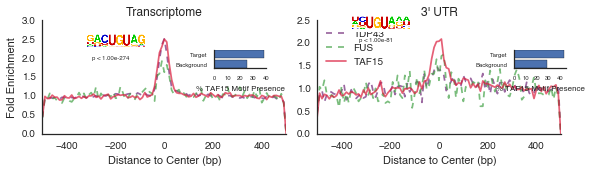

In [207]:
num_rows = 1
num_cols = 2
subax_rect_1 = [.1, .7, .2, .1]
bar_plot_rect_1 = [.38, .60, .09, .1]
bar_plot_rect_2 = [.9, .60, .09, .1]
subax_rect_2 = [.56, .8, .2, .1]

with dataviz.Figure(os.path.join(img_dir, "distance.svg"), figsize=(num_cols * 4,num_rows * 2.5)) as fig:
    #All Regions Code
    ax = fig.add_subplot(num_rows,num_cols,1)
    for rbp in rbps:
        result = annotatePeaks(peaks=assigned_rbps[rbp]['all']['real'].fn, motif=all_motif1_file, species="mm9")
        result = result[result.columns[1]]
        ax.plot(result.index, 
                result / np.median(result),
                label=name_map[rbp],
                linestyle=style_map[rbp], 
                color= color_map[rbp],
                alpha=.7)
        
    ax.set_xlim(-500, 500)
    ax.set_title("Transcriptome")
    ax.set_ylabel("Fold Enrichment")
    ax.set_xlabel("Distance to Center (bp)")
    
    #Plot the Motif
    subax = fig.add_axes(subax_rect_1)
    subax.imshow(all_motif1_image)
    sns.despine(bottom=True,left=True, ax=subax)
    subax.set_xticks([])
    subax.set_yticks([])
    subax.set_xlabel('p < {:.2e}'.format(all_motif1_pvalue), fontsize=6)
    sns.despine(ax=ax)

    #Plot the bar char
    ax = fig.add_axes(bar_plot_rect_1)
    pos = np.arange(2)
    ax.barh(pos, [all_motif1_background, all_motif1_target], align="center")
    ax.set_yticks(pos)
    ax.set_yticklabels(["Background", "Target"], fontsize=8)
    ax.set_xticks(ax.get_xticks()[::2])
    sns.despine(ax=ax)
    ax.set_xlabel("% TAF15 Motif Presence", fontsize=8)
    [tick.set_fontsize(6) for tick in ax.get_yticklabels()]
    [tick.set_fontsize(6) for tick in ax.get_xticklabels()]

    #3' UTR Code
    ax = fig.add_subplot(num_rows,num_cols,2)
    subax = fig.add_axes(subax_rect_2)
    
    for rbp in rbps:
        result = annotatePeaks(peaks=assigned_rbps[rbp]['three_prime_utrs']['real'].fn, motif=utr3_motif1_file, species="mm9")
        result = result[result.columns[1]]
        ax.plot(result.index, 
                result / np.median(result),
                label=name_map[rbp],
                linestyle=style_map[rbp], 
                color= color_map[rbp],
                alpha=.7)
        
    ax.set_xlim(-500, 500)
    ax.legend(loc=0)
    subax.imshow(utr3_motif1_image)
    sns.despine(bottom=True,left=True, ax=subax)
    subax.set_xticks([])
    subax.set_yticks([])
    subax.set_xlabel('p < {:.2e}'.format(utr3_motif1_pvalue), fontsize=6)
    sns.despine(ax=ax)
    ax.set_title("3' UTR")
    ax.set_xlabel("Distance to Center (bp)")
    
    #Plot the bar char
    ax = fig.add_axes(bar_plot_rect_2)
    pos = np.arange(2)
    ax.barh(pos, [utr3_motif1_background, utr3_motif1_target], align="center")
    ax.set_yticks(pos)
    ax.set_yticklabels(["Background", "Target"], fontsize=8)
    ax.set_xticks(ax.get_xticks()[::2])
    sns.despine(ax=ax)
    ax.set_xlabel("% TAF15 Motif Presence", fontsize=8)
    [tick.set_fontsize(6) for tick in ax.get_yticklabels()]
    [tick.set_fontsize(6) for tick in ax.get_xticklabels()]

Figure Legend: Distance of TAF15 Motifs away from binding sites, FUS and TDP43 used as background control for motif in whole transcriptome and 3' UTR were used in this analysis

In [213]:
img_dir

'/nas3/gpratt/Dropbox/TAF15/Data/GP_TAF15_CLIP_motif/'

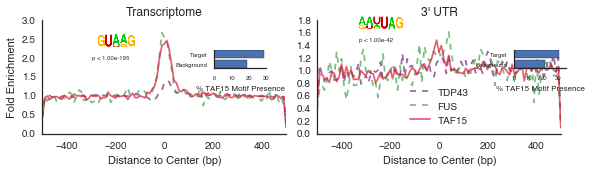

In [212]:
num_rows = 1
num_cols = 2
subax_rect_1 = [.1, .7, .2, .1]
bar_plot_rect_1 = [.38, .60, .09, .1]
bar_plot_rect_2 = [.9, .60, .09, .1]
subax_rect_2 = [.56, .8, .2, .1]

with dataviz.Figure(os.path.join(img_dir, "distance_second_best.svg"), figsize=(num_cols * 4,num_rows * 2.5)) as fig:
    #All Regions Code
    ax = fig.add_subplot(num_rows,num_cols,1)
    for rbp in rbps:
        result = annotatePeaks(peaks=assigned_rbps[rbp]['all']['real'].fn, motif=utr3_motif1_file, species="mm9")
        result = result[result.columns[1]]
        ax.plot(result.index, 
                result / np.median(result),
                label=name_map[rbp],
                linestyle=style_map[rbp], 
                color= color_map[rbp],
                alpha=.7)
        
    ax.set_xlim(-500, 500)
    ax.set_title("Transcriptome")
    ax.set_ylabel("Fold Enrichment")
    ax.set_xlabel("Distance to Center (bp)")
    
    #Plot the Motif
    subax = fig.add_axes(subax_rect_1)
    subax.imshow(all_motif2_image)
    sns.despine(bottom=True,left=True, ax=subax)
    subax.set_xticks([])
    subax.set_yticks([])
    subax.set_xlabel('p < {:.2e}'.format(all_motif2_pvalue), fontsize=6)
    sns.despine(ax=ax)

    #Plot the bar char
    ax = fig.add_axes(bar_plot_rect_1)
    pos = np.arange(2)
    ax.barh(pos, [all_motif2_background, all_motif2_target], align="center")
    ax.set_yticks(pos)
    ax.set_yticklabels(["Background", "Target"], fontsize=8)
    ax.set_xticks(ax.get_xticks()[::2])
    sns.despine(ax=ax)
    ax.set_xlabel("% TAF15 Motif Presence", fontsize=8)
    [tick.set_fontsize(6) for tick in ax.get_yticklabels()]
    [tick.set_fontsize(6) for tick in ax.get_xticklabels()]

    #3' UTR Code
    ax = fig.add_subplot(num_rows,num_cols,2)
    subax = fig.add_axes(subax_rect_2)
    
    for rbp in rbps:
        result = annotatePeaks(peaks=assigned_rbps[rbp]['three_prime_utrs']['real'].fn, motif=utr3_motif2_file, species="mm9")
        result = result[result.columns[1]]
        ax.plot(result.index, 
                result / np.median(result),
                label=name_map[rbp],
                linestyle=style_map[rbp], 
                color= color_map[rbp],
                alpha=.7)
        
    ax.set_xlim(-500, 500)
    ax.legend(loc=0)
    subax.imshow(utr3_motif2_image)
    sns.despine(bottom=True,left=True, ax=subax)
    subax.set_xticks([])
    subax.set_yticks([])
    subax.set_xlabel('p < {:.2e}'.format(utr3_motif2_pvalue), fontsize=6)
    sns.despine(ax=ax)
    ax.set_title("3' UTR")
    ax.set_xlabel("Distance to Center (bp)")
    
    #Plot the bar char
    ax = fig.add_axes(bar_plot_rect_2)
    pos = np.arange(2)
    ax.barh(pos, [utr3_motif2_background, utr3_motif2_target], align="center")
    ax.set_yticks(pos)
    ax.set_yticklabels(["Background", "Target"], fontsize=8)
    ax.set_xticks(ax.get_xticks()[::2])
    sns.despine(ax=ax)
    ax.set_xlabel("% TAF15 Motif Presence", fontsize=8)
    [tick.set_fontsize(6) for tick in ax.get_yticklabels()]
    [tick.set_fontsize(6) for tick in ax.get_xticklabels()]

#Overlapping Peak Information

In [191]:
def annotatePeaks(peaks, motif, species="hg19", hist=10, size=1000):
    
    """
    
    runs homer with standard args
    output location is saved
    
    foreground - str, location of fasta file for the foreground distribution
    background - str, location of fasta file for the background distribution
    k - different k-mers to examine
    outloc - directory to output homer results 

    --make optional make work off locations and not fasta files 
    
    """
    #findMotifs.pl clusters.fa fasta outloc -nofacts p 4 -rna -S 10 -len 5,6,7,8,9 -noconvert -nogo -fasta background.fa
    #converts k to a string for use in subprocess
    #I'm forgetting strand specific information here
    try:
        with open("tmp.txt", 'w') as out:
            subprocess.call(["annotatePeaks.pl",
                             peaks,
                             species,
                             "-m", motif,
                             #"-hist", str(hist),
                             "-size", "given",
                             "-noann"], shell=False, stdout=out)
    except OSError:
        print "Homer not installed, ignoring motif generation, install homer for this to work"  
        raise   
    return pd.read_table("tmp.txt", index_col=0)

def get_strand_of_motif(motifs):
    try:
        return ",".join(list(set(motif.split(",")[1] for motif in motifs.split("),"))))
    except AttributeError:
        return np.nan
def bound(row):
    try:
        return row.Strand in row.motif_strands
    except TypeError:
        return False

In [192]:
def get_bound_motifs(bedtool, motif_file, motif_name):
    annoted_peaks = annotatePeaks(bedtool.fn, motif_file, "mm9")
    annoted_peaks['motif_strands'] = annoted_peaks['1-{} Distance From Peak(sequence,strand,conservation)'.format(motif_name)].apply(get_strand_of_motif)
    annoted_peaks['motif_present'] = annoted_peaks.apply(bound, axis=1)
    return annoted_peaks

#What is the likelyhood that an overlapped peak will contain the motif vs a unique peak?

In [193]:
gguag_motif = "gguag.motif"
gugg_motif = "gugg.motif"

In [194]:
fus_and_taf15_peaks = assigned_rbps["fus"]['all']['real'].intersect(assigned_rbps["taf15"]['all']['real'], u=True, s=True).saveas()
taf15_and_fus_peaks = assigned_rbps["taf15"]['all']['real'].intersect(assigned_rbps["fus"]['all']['real'], u=True, s=True).saveas()

only_fus_peaks = assigned_rbps["fus"]['all']['real'].intersect(assigned_rbps["taf15"]['all']['real'], v=True, s=True).saveas()
only_taf15_peaks = assigned_rbps["taf15"]['all']['real'].intersect(assigned_rbps["fus"]['all']['real'], v=True, s=True).saveas()

In [195]:
taf15_gguag_motif = get_bound_motifs(assigned_rbps["taf15"]['all']['real'], gguag_motif, "GGUAG")
fus_gguag_motif= get_bound_motifs(assigned_rbps["fus"]['all']['real'], gguag_motif, "GGUAG")
taf15_gugg_motif= get_bound_motifs(assigned_rbps["taf15"]['all']['real'], gugg_motif, "GUGG")
fus_gugg_motif= get_bound_motifs(assigned_rbps["fus"]['all']['real'], gugg_motif, "GUGG")

taf15_and_fus_gguag_motif = get_bound_motifs(taf15_and_fus_peaks, gguag_motif, "GGUAG")
fus_and_taf15_gguag_motif= get_bound_motifs(fus_and_taf15_peaks, gguag_motif, "GGUAG")
taf15_and_fus_gugg_motif= get_bound_motifs(taf15_and_fus_peaks, gugg_motif, "GUGG")
fus_and_taf15_gugg_motif= get_bound_motifs(fus_and_taf15_peaks, gugg_motif, "GUGG")

only_fus_gguag_motif = get_bound_motifs(only_fus_peaks, gguag_motif, "GGUAG")
only_taf155_gguag_motif= get_bound_motifs(only_taf15_peaks, gguag_motif, "GGUAG")
only_fuss_gugg_motif= get_bound_motifs(only_fus_peaks, gugg_motif, "GUGG")
only_taf15_gugg_motif= get_bound_motifs(only_taf15_peaks, gugg_motif, "GUGG")

In [196]:
print sum(fus_and_taf15_gugg_motif.motif_present) / (len(fus_and_taf15_gugg_motif) * 1.0)

0.189828080229


In [197]:
print sum(taf15_and_fus_gguag_motif.motif_present) / (len(taf15_and_fus_gguag_motif) * 1.0)

0.0868935553946


In [198]:
print sum(only_taf155_gguag_motif.motif_present) / (len(only_taf155_gguag_motif) * 1.0)
print sum(only_taf15_gugg_motif.motif_present) / (len(only_taf15_gugg_motif) * 1.0)


0.0611514225702
0.273248042773


In [199]:
print sum(only_fus_gguag_motif.motif_present) / (len(only_fus_gguag_motif) * 1.0)
print sum(only_fuss_gugg_motif.motif_present) / (len(only_fuss_gugg_motif) * 1.0)


0.0338541666667
0.167317708333
